## Problem Set 4

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

### 1.1 Question 1

In [2]:
df = pd.read_csv("/Users/zhengyaojin/Desktop/ad_heterog.csv")
df.head()

,revenue,treatment,demographic_1,demographic_2,demographic_3,demographic_4,demographic_5,demographic_6,demographic_7,demographic_8,...,demographic_21,demographic_22,demographic_23,demographic_24,demographic_25,demographic_26,demographic_27,demographic_28,demographic_29,demographic_30
0,5.504899,0,1,1,1,0,0,1,1,1,...,1,1,1,1,0,1,1,1,0,1
1,5.554275,1,0,1,1,0,0,0,1,0,...,0,0,0,1,1,0,1,1,1,0
2,5.219492,0,0,1,1,0,0,1,1,1,...,0,1,0,1,0,1,1,0,0,1
3,4.565855,0,1,0,0,0,1,1,0,1,...,1,0,0,1,0,1,0,0,1,0
4,5.020636,0,1,1,0,1,0,0,1,1,...,1,1,0,0,1,1,0,0,0,1


In [3]:
simple_model = smf.ols(formula = 'revenue ~ treatment', data = df).fit()
print(simple_model.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     779.2
Date:                Sat, 16 Mar 2024   Prob (F-statistic):          4.50e-145
Time:                        19:19:14   Log-Likelihood:                -1532.5
No. Observations:                2000   AIC:                             3069.
Df Residuals:                    1998   BIC:                             3080.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1082      0.016    315.942      0.0

### Interpretation:

Intercept: This represents the average revenue for the control group, which is 5.1082 units. This is significant as shown by the small p-value. 

Treatment: This shows that for each unit increase in treatment, revenue is expected to increase by 0.6508 units. In other words, this represents the incremental effect of the treatment with respect to the treatment group. This is also statistically significant as manifested by the small p-value.

### 1.1 Question 2

I would not show the ads because the incremental value is 0.6508, which is less than 0.7 dollars, the cost of showing the ads. 

### 2. Question 1

In [4]:
# extract columns pertaining to demographic information (all columns except first two)
demo_matrix = df.iloc[:,2:]

# generate interactions of each demographic variable with the treatment variable
demo_treat_matrix = demo_matrix.multiply(df['treatment'], axis="index")
demo_treat_matrix.columns = demo_treat_matrix.columns.str.replace("demographic", "treat_demo")

# generate treatment variable that is outside of data-frame (useful below)
treatment = df['treatment']


In [5]:
from scipy import sparse
from sklearn import linear_model
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

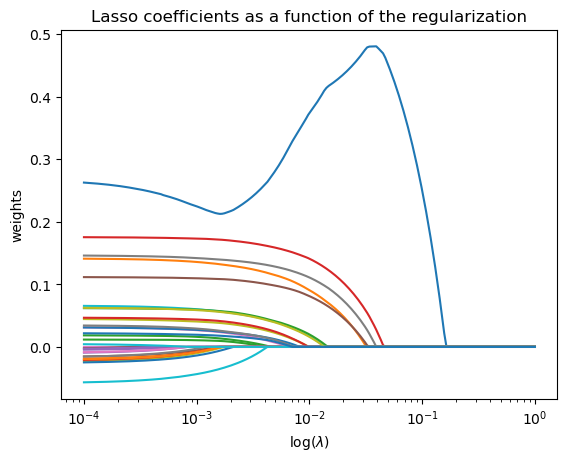

In [7]:
# X variables
x = sparse.csc_matrix(pd.concat([treatment, demo_treat_matrix], axis=1))
# Y variable 
Y = df["revenue"]
coefs = []
n_alphas = 200
alphas = np.logspace(-4, 0, n_alphas)
for a in alphas:
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(x, Y)
    coefs.append(lasso.coef_)

# Show the plot
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
plt.xlabel("$\log(\lambda)$")
plt.ylabel("weights")
plt.title("Lasso coefficients as a function of regularization") 
plt.axis("tight")
plt.show()

Answer: In the context of a Lasso regression model that utilizes a matrix of treatment and interaction terms, the non-monotonic patterns observed in the coefficients could stem from the interactions between the treatment and other variables in the model. At the outset, there's an increase in the importance of a particular coefficient as the model accentuates it, simultaneously reducing others to zero. As lambda decreases, which broadens the spectrum of variables included in the model, this heightened emphasis begins to diminish. The dynamics between the coefficient highlighted by the blue line and other variables can shift the significance of certain variables as the penalty parameter is modified, leading to the coefficients demonstrating non-monotonic movements.

### 2. Question 2

In [8]:
nfolds  = 10
lassocv = LassoCV(alphas = None, cv = nfolds, max_iter = 10000)
lassocv.fit(x,Y)

LassoCV(cv=10, max_iter=10000)

In [10]:
# obtaining the coefficients that are not zero and return them
def get_coef(lasso,scale,coeffnames):
    coefficients = np.append(lasso.intercept_, lasso.coef_) 
    coeffnames = coeffnames[coefficients != 0]
    coeffvalues = coefficients[coefficients != 0]
    return pd.DataFrame([coeffnames, coeffvalues]).T

In [18]:
combined_col = pd.concat([treatment, demo_treat_matrix], axis=1).columns
coeff_names = ['(Intercept)'] + list(combined_col)
coeff_names_array = np.array(coeff_names)
coefficients = get_coef(lassocv, 1, coeff_names_array)
coefficients


,0,1
0,(Intercept),5.117759
1,treatment,0.280851
2,treat_demo_1,0.114795
3,treat_demo_3,0.158607
4,treat_demo_7,0.128264
5,treat_demo_9,0.040007
6,treat_demo_16,0.006887
7,treat_demo_18,0.022377
8,treat_demo_20,0.012228
9,treat_demo_22,0.041163


The interaction term coefficients indicate the varied responses to the treatment among each demographic group compared to the base group. From the results presented, it is evident that all mentioned demographic groups exhibit a more positive reaction to the treatment than the base groups do. The result suggests that we should focus our advertising efforts on the identified demographic areas due to the notable rise in revenue observed there, while advising against investing in advertising in locations that were not selected.

### 3. Question 1

In [23]:
combined_df = pd.concat([treatment, demo_matrix, demo_treat_matrix], axis=1)
x = sparse.csc_matrix(combined_df)

# Run Lasso CV
nfolds  = 10
lassocv = LassoCV(alphas = None, cv = nfolds, max_iter = 10000) 
lassocv.fit(x,Y)

LassoCV(cv=10, max_iter=10000)

In [27]:
coeff_name = list(pd.concat([treatment, demo_matrix, demo_treat_matrix], axis=1).columns)
coeff_name.insert(0, '(Intercept)')
coeff_name_array = np.array(coeff_name)
coefficients = get_coef(lassocv, 1, coeff_name_array)
coefficients

,0,1
0,(Intercept),4.964982
1,treatment,0.454866
2,demographic_1,0.138043
3,demographic_2,-0.002787
4,demographic_7,0.016443
5,demographic_9,0.034156
6,demographic_11,-0.014056
7,demographic_22,0.032252
8,demographic_23,0.020893
9,demographic_25,0.068269


Answer: As for demographics 3, the treatment effect of 0.609768 is the treatment coefficient 0.454886 plus the coefficient for the interaction term 0.154882. But we cannot distinguish individuals that have same characteristics in the control group from the baseline, which is represented by the intercept, since the lasso regression did not pick the dummy for demographic_3 .

For demographics 7, the treatment effect of 0.562186 is the sum of the treatment coefficient 0.454886 plus the coefficient for the interaction term 0.1073. Here we can compute both the predicted revenue for the control group and the treatment group for demo 7 since the lasso regression selected both the demographic_7 and the intersection term.



### 3. Question 2

In [69]:
is_treated = df["treatment"] >= 0
treated_indicator = is_treated.astype(int)
demo_treated = demo_matrix.multiply(treated_indicator, axis='index')
demo_treated.rename(columns=lambda x: x.replace('demographic', 'treat_demo'), inplace=True)
X_treated = sparse.csc_matrix(pd.concat([treated_indicator, demo_matrix, demo_treated], axis=1))

untreated = (df["treatment"] < 0).astype(int)
demo_untreated = demo_matrix.multiply(untreated, axis='index')
demo_untreated.columns = demo_untreated.columns.str.replace('demographic', 'treat_demo')
X_untreated = sparse.csc_matrix(pd.concat([untreated, demo_matrix, demo_untreated], axis=1))

df["treatment_rev"] = lassocv.predict(X_treated)
df["baseline_rev"] = lassocv.predict(X_untreated)

profit_threshold = 0.7$
df["showad"] = (df["treatment_rev"] - df["baseline_rev"]) > profit_threshold
df["profit_without_ad"] = df["treatment_rev"] - df["baseline_rev"] - profit_threshold
df["profit_with_ad"] = df["showad"].astype(int) * df["profit_without_ad"]

In [70]:
# expected profit per consumer
np.mean(df["profit_without_ad"])

-0.06826410916798291

In [71]:
np.mean(df["profit_with_ad"])

0.01613243404540253

Answer: The expected profit per customer when showing the ad to everyone is -0.0683 while the expected profit when only showing the ad to customers with positive expected profit is 0.0161